In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

%config InlineBackend.figure_format = 'svg'

In [5]:
DATA_DIR = '../../datasets/'

df = pd.read_csv(f'{DATA_DIR}tokenized/blog_authorship_tokenized.csv', usecols=['text', 'tokenized', 'age_group'])
df.sample(5)

,text,age_group,tokenized
430664,I thought our team blog needed a little spruci...,25-34,i thought our team blog needed a little spruci...
436842,My first Toronto gig a couple of years ago. F...,18-24,my first toronto gig a couple of years ago ....
632190,Friday Five You know who it's from 1. What foo...,18-24,friday five you know who it 's from 1 . what f...
411839,Help your karma by helping me get a free iPod ...,25-34,help your karma by helping me get a free ipod ...
411926,It's a USB dongle with a fingerprint reader. T...,25-34,it 's a usb dongle with a fingerprint reader ....


In [7]:
df['age_group'].value_counts(dropna=False)

<18      218124
25-34    195382
18-24    142348
>35       79745
Name: age_group, dtype: int64

In [30]:
df_ = df.copy()
df_['age_group'].value_counts(dropna=False)

<18      218124
25-34    195382
18-24    142348
>35       79745
Name: age_group, dtype: int64

In [31]:
df_ = df_.dropna()
print(df_.shape)

(635599, 3)


In [32]:
enc = LabelEncoder()
enc.fit(df_['age_group'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
df_['age_group'] = enc.transform(df_['age_group'])
encoded_labels

{'18-24': 0, '25-34': 1, '<18': 2, '>35': 3}

In [33]:
X = df_['text']
y = df_['age_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((508479,), (127120,), (508479,), (127120,))

In [34]:
vect = TfidfVectorizer()
svm = LinearSVC()

pipe = make_pipeline(vect, svm)

In [35]:
param_grid = {
    'tfidfvectorizer__ngram_range': [(1, 1)],
    'linearsvc__random_state': [97],
}

In [36]:
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5)

gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'linearsvc__random_state': 97, 'tfidfvectorizer__ngram_range': (1, 1)}


In [37]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.40      0.45     28604
           1       0.55      0.63      0.59     39238
           2       0.74      0.83      0.78     43419
           3       0.56      0.39      0.46     15859

    accuracy                           0.62    127120
   macro avg       0.59      0.56      0.57    127120
weighted avg       0.61      0.62      0.61    127120



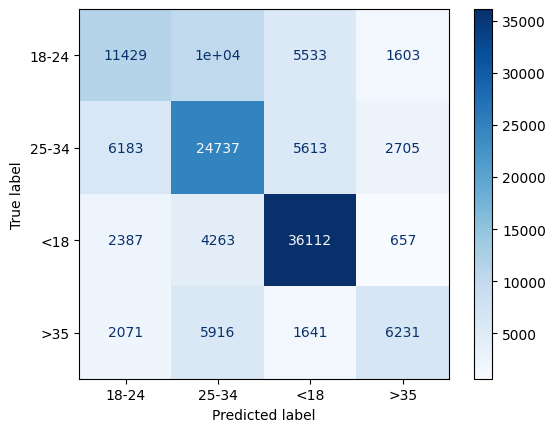

In [38]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues');

In [39]:
import joblib

joblib.dump(gs, 'age_baseline.joblib')

['age_baseline.joblib']

## Test the model

In [58]:
model = joblib.load('age_baseline.joblib')

def predict_age(text):
    classes = encoded_labels
    classes = {v: k for k, v in classes.items()} # reverse the dict
    return classes[model.predict([text])[0]]

In [59]:
predict_age("Thanks to the best teams ever for making it possible!") # 33 -> Correct

'25-34'

In [60]:
predict_age("I am a 20 year old student from the Netherlands") # 20 -> Wrong

'<18'

In [61]:
predict_age("It's a USB dongle with a fingerprint reader.") # 19 -> Correct

'18-24'

In [62]:
predict_age("I welcome the opportunity to meet the EU fishing sector in person and answer their questions about our EU Implementing Act on vulnerable marine ecosystems today.") # 31 -> Correct

'25-34'